In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Load world cities requests...
requests = []
# Open the CSV and process the lines
with open('../../data/worldcities/worldcities.csv', 'r', encoding='utf8') as f:
    f.readline()  # Skip the header line
    i = 0
    for line in f:
        parts = re.split(r'(?:",")|"', line)
        # Extract the latitude, longitude, and city name
        lat = float(parts[3])
        lon = float(parts[4])
        city = parts[2]
        # Create a new Request object and append it to the list
        requests.append(Request(len(requests), lat, lon, city))
        i += 1
        if i >= 4000:
            break

In [4]:
h = 400
print(accesses[0])
print([a for a in accesses if a.name == 'London'])
seconds_since_epoch = (t0 - Constants.J2000).total_seconds()
print(ecef2latlong(eci2ecef((kepler2eci(orbit)[0]), t0)))

# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features to the map
ax.stock_img()
# ax.add_feature(cfeature.LAND, facecolor='#A7C957')
# ax.add_feature(cfeature.OCEAN, facecolor='#A2D2FF')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

if(len(accesses) > 0):
    access_latlongs = np.unique(np.array([[a.lat, a.long] for a in accesses]), axis=0)
else:
    access_latlongs = []
    
req_latlongs = np.array([[x.lat, x.long] for x in requests if [x.lat, x.long] not in access_latlongs])

def split_orbit_track(latlongs, threshold=180):
    lat, long = np.array(latlongs)[:, 0], np.array(latlongs)[:, 1]
    # Calculate the difference between consecutive longitudes
    delta_long = np.abs(np.diff(long))
    
    # Identify where the jump exceeds the threshold
    jump_indices = np.where(delta_long > threshold)[0] + 1
    
    # Split the data at the jump indices
    segments = np.split(latlongs, jump_indices)
    return segments

ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_title('Ground Track')

t_span = range(int((t_end - t0).total_seconds()))
segments = split_orbit_track([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=t)) for t in t_span])
for i, segment in enumerate(segments):
    if len(segment) == 0:
        continue  # Skip empty segments
    ax.plot(
        segment[:, 1],
        segment[:, 0],
        color='blue',
        label=f"Orbit Track" if i == 0 else None,
        transform=ccrs.PlateCarree()
    )

ax.plot(req_latlongs[:, 1], req_latlongs[:, 0], '.r', markersize=1, label="All Requests", transform=ccrs.PlateCarree())
ax.plot(access_latlongs[:, 1], access_latlongs[:, 0], '.g', markersize=1, label="Obtained Accesses", transform=ccrs.PlateCarree())

plt.show()

NameError: name 'accesses' is not defined

In [5]:
t = t0 + datetime.timedelta(seconds=0)

def get_latlonglines_eci(orbit, t):
    # Generate some latlong lines
    lats = np.linspace(-90, 90, 19)
    lons = np.linspace(-180, 180, 37)

    lats_fine = np.linspace(-90, 90, 181)
    lons_fine = np.linspace(-180, 180, 361)

    lat_lines_lons = np.repeat(lons, len(lats_fine))
    lat_lines_lats = np.tile(lats_fine, (len(lons),))

    long_lines_lats = np.repeat(lats, len(lons_fine))
    long_lines_lons = np.tile(lons_fine, (len(lats),))

    ecef_latlines = latlong2ecef_vec(np.stack([lat_lines_lats, lat_lines_lons], axis=1))
    ecef_lonlines = latlong2ecef_vec(np.stack([long_lines_lats, long_lines_lons], axis=1))

    eci_latlines = ecef2eci_vec(ecef_latlines, t)
    eci_lonlines = ecef2eci_vec(ecef_lonlines, t)

    orbit_propagated = propagate_orbit(orbit, (t-t0).total_seconds())
    r, v = kepler2eci(orbit_propagated)

    horizon = horizon_distance(orbit)

    # Calculate lat lines in horizon distance
    eci_latlines = eci_latlines[dist(eci_latlines, r) < horizon]
    eci_lonlines = eci_lonlines[dist(eci_lonlines, r) < horizon]

    return eci_latlines, eci_lonlines

r, v = kepler2eci(orbit)
latlines, lonlines = get_latlonglines_eci(orbit, t)
orbit_latlong = ecef2latlong(eci2ecef(r, t))

plt.figure()
# plt.plot(latlines[:, 1], latlines[:, 0], 'r.')
# plt.plot(lonlines[:, 1], lonlines[:, 0], 'b.')
plt.plot(orbit_latlong[1], orbit_latlong[0], 'go')
plt.show()

NameError: name 't0' is not defined

In [6]:
def rotation_matrix(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Computes the rotation matrix that rotates the standard basis vectors
    x = [1, 0, 0] and y = [0, 1, 0] to the provided orthogonal vectors a and b.

    Parameters:
    a (np.ndarray): The target vector for the x-axis (should be a 3-element array).
    b (np.ndarray): The target vector for the y-axis (should be a 3-element array).

    Returns:
    np.ndarray: A 3x3 rotation matrix.
    
    Raises:
    ValueError: If the input vectors are not 3-dimensional or not orthogonal.
    """
    # Ensure input vectors are numpy arrays
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    
    # Check if vectors are 3-dimensional
    if a.shape != (3,) or b.shape != (3,):
        raise ValueError("Input vectors must be three-dimensional.")
    
    # Normalize the vectors
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    
    if a_norm == 0 or b_norm == 0:
        raise ValueError("Input vectors must be non-zero.")
    
    a_unit = a / a_norm
    b_unit = b / b_norm
    
    # Check orthogonality
    dot_product = np.dot(a_unit, b_unit)
    if not np.isclose(dot_product, 0.0, atol=1e-8):
        raise ValueError("Input vectors must be orthogonal.")
    
    # Compute the third orthogonal vector using cross product
    c_unit = np.cross(a_unit, b_unit)
    
    # Form the rotation matrix with a_unit, b_unit, c_unit as columns
    R = np.column_stack((a_unit, b_unit, c_unit))
    
    # Verify that R is a valid rotation matrix
    if not np.allclose(np.dot(R, R.T), np.identity(3), atol=1e-8):
        raise ValueError("Resulting matrix is not orthogonal.")
    if not np.isclose(np.linalg.det(R), 1.0, atol=1e-8):
        raise ValueError("Resulting matrix does not have a determinant of +1.")
    
    return R


def project_from_orbit(points, orbit, time, roll_angle=0):
    width = 800
    height = 600
    r, v = kepler2eci(propagate_orbit(orbit, time))
    K = get_intrinsics(300, width//2, height//2)
    # Figure out the quaternion pointing to nadir
    v_unit = v / np.linalg.norm(v)
    r_unit = r / np.linalg.norm(r)

    R_t = rotation_matrix(r_unit, -v_unit)
    R_q = eul2R(0, np.deg2rad(roll_angle), np.deg2rad(15))
    R_t = R_t @ R_q
    R_t = np.linalg.inv(R_t)
    R_t = R_t[[2, 1, 0], :]
    P = get_camera_matrix(K, R_t, r)
    projected_points = project(P, points, False)
    # projected_points[:, 0] = width - projected_points[:, 0]
    return projected_points

t_s = 20
t_dot = 1

def agility(theta):
    return t_s + np.abs(t_dot * theta)

def roll_angle(t, r1, r2, agility):
    s = (r2.time - r1.time).total_seconds()
    t_s = agility(0)
    return (r1.angle + (r2.angle - r1.angle) * (((t - r1.time).total_seconds()) / (s)))

# generate a schedule...
# Append random states to the accesses..
np.random.seed(0)
for i, r in enumerate(accesses):
    r.state = {
        "occluded": np.random.randint(0, 2),
        "observed": False
        }

schedule = greedy_schedule(accesses, requests, agility)
requests_in_schedule = [requests[r.requestid] for r in schedule]
print(schedule)

NameError: name 'accesses' is not defined

NameError: name 'schedule' is not defined

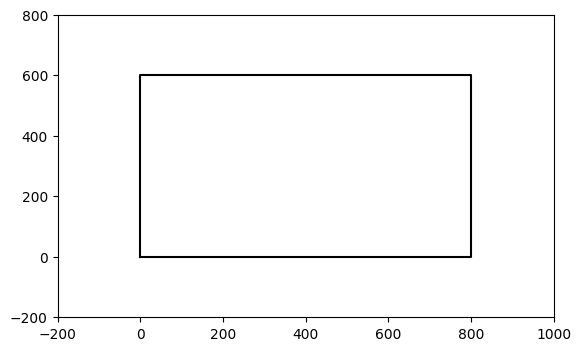

In [7]:
# for a in accesses:
#     a.state["observed"] = False

# Initialize the figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)  # Make space for the slider

# Initialize plot elements
lat_line, = ax.plot([], [], 'b.', label='Latitude Lines', markersize=1)
lon_line, = ax.plot([], [], 'r.', label='Longitude Lines', markersize=1)
requests_unobserved_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'white',markeredgecolor='black')
requests_occluded_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'red',markeredgecolor='red')
requests_unoccluded_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'green',markeredgecolor='green')
requests_other_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'white',markeredgecolor='black')

schedule_line, = ax.plot([], [], 'c', label='Schedule', markerfacecolor='limegreen',markeredgecolor='black')
orbit_line, = ax.plot([], [], 'yo', label='Orbit')
camera_line, = ax.plot([], [], 'ko', label='Camera')
width = 800
height = 600
box = np.array([[0, 0, 0], [width, 0, 0], [width, height, 0], [0, height, 0], [0, 0, 0]])

box_line, = ax.plot(box[:, 0], box[:, 1], 'k-', label='Box')

# Set plot limits
ax.set_xlim([-200, width + 200])
ax.set_ylim([-200, height + 200])
print(schedule)
s = 26 * 60
t = t0 + datetime.timedelta(seconds=s)
# print(f"t: {t}, {{schedule[0].time >= t}") 
horizon = horizon_distance(orbit)
r, v = kepler2eci(propagate_orbit(orbit, s))
# Get current index of requests
next_task_idx = next((i for i, r in enumerate(schedule) if r.time >= t), len(schedule))
roll = 0
if next_task_idx > 0 and next_task_idx < len(schedule):
    roll = -roll_angle(t, schedule[next_task_idx - 1], schedule[next_task_idx], agility)
else: 
    roll = 0

latlines, lonlines = get_latlonglines_eci(orbit, t)
projected_latlines = project_from_orbit(latlines, orbit, (t - t0).total_seconds(), roll)
projected_lonlines = project_from_orbit(lonlines, orbit, (t - t0).total_seconds(), roll)
projected_orbit = project_from_orbit((r * (Constants.R_E/(orbit.a + Constants.R_E)))[np.newaxis, :], orbit, (t - t0).total_seconds(), roll)
# print(f"Roll: {roll}")
r_unit = r / np.linalg.norm(r)
v_unit = v / np.linalg.norm(v)

intersect = earth_line_intersection(r, (r_unit * np.cos(np.deg2rad(roll))) + (np.cross(r_unit, v_unit) * np.sin(np.deg2rad(roll))))

# Update data for each plot element
def project_requests(requests, orbit, t, roll, horizon_filter=True):
    if(len(requests) == 0):
        return None
    
    requests_latlongs = np.array([[x.lat, x.long] for x in requests])
    requests_eci = ecef2eci_vec(latlong2ecef_vec(requests_latlongs), t)
    if(horizon_filter):
        requests_eci = requests_eci[dist(requests_eci, r) < horizon]

    return project_from_orbit(requests_eci, orbit, (t - t0).total_seconds(), roll)

requests_observed_mask = np.zeros(len(requests), dtype=bool)

for i, x in enumerate(accesses):
    requests_observed_mask[x.requestid] = x.state["observed"]

requests_unobserved = [a for a in accesses if not a.state["observed"]]
requests_occluded = [a for a in accesses if a.state["observed"] and a.state["occluded"]]
requests_unoccluded = [a for a in accesses if a.state["observed"] and not a.state["occluded"]]

projected_requests_unobserved = project_requests(requests_unobserved, orbit, t, roll)
projected_requests_occluded = project_requests(requests_occluded, orbit, t, roll)
projected_requests_unoccluded = project_requests(requests_unoccluded, orbit, t, roll)
request_mask = np.ones(len(requests), dtype=bool)
for i in accesses:
    request_mask[i.requestid] = False

all_other_requests = [requests[i] for i in range(len(requests)) if request_mask[i]]
projected_requests_other = project_requests(all_other_requests, orbit, t, roll)

# Update ones that are in the projection
requests_projected_all = project_requests(accesses, orbit, t, roll, False)
for p, a in zip(requests_projected_all, accesses):
    if(p[0] >= 0 and p[0] <= width and p[1] >= 0 and p[1] <= height):
        a.state["observed"] = True
    
requests_in_schedule = [requests[a.requestid] for a in schedule if a.time >= t]

projected_earth_intersection = None
if intersect is not None:
    # print(f"Intersect: {intersect}")
    # Pick the closest intersection
    intersect = sorted(intersect, key=lambda x: np.linalg.norm(x - r))
    # print(np.linalg.norm(intersect[0] - r))
    projected_earth_intersection = project_from_orbit(intersect[0][np.newaxis, :], orbit, (t - t0).total_seconds(), roll)

projected_schedule = projected_earth_intersection
if(len(requests_in_schedule) > 0):  
    schedule_latlongs = np.array([[x.lat, x.long] for x in requests_in_schedule])
    schedule_eci = ecef2eci_vec(latlong2ecef_vec(schedule_latlongs), t)
    schedule_eci = schedule_eci[dist(schedule_eci, r) < horizon]
if(projected_earth_intersection is not None):
    camera_line.set_data(projected_earth_intersection[:, 0], projected_earth_intersection[:, 1])    
    projected_schedule = np.concatenate([projected_earth_intersection, project_from_orbit(schedule_eci, orbit, (t - t0).total_seconds(), roll)])

lat_line.set_data(projected_latlines[:, 0], projected_latlines[:, 1])
lon_line.set_data(projected_lonlines[:, 0], projected_lonlines[:, 1])
orbit_line.set_data(projected_orbit[:, 0], projected_orbit[:, 1])

if(projected_requests_unobserved is not None):
    requests_unobserved_line.set_data(projected_requests_unobserved[:, 0], projected_requests_unobserved[:, 1])

if(projected_requests_occluded is not None):
    requests_occluded_line.set_data(projected_requests_occluded[:, 0], projected_requests_occluded[:, 1])

if(projected_requests_unoccluded is not None):
    requests_unoccluded_line.set_data(projected_requests_unoccluded[:, 0], projected_requests_unoccluded[:, 1])

requests_other_line.set_data(projected_requests_other[:, 0], projected_requests_other[:, 1])

schedule_line.set_data(projected_schedule[:, 0], projected_schedule[:, 1])


In [8]:
import matplotlib.animation as animation
from matplotlib.widgets import Slider
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\shree\\AppData\\Local\\Microsoft\\WinGet\\Packages\\Gyan.FFmpeg.Essentials_Microsoft.Winget.Source_8wekyb3d8bbwe\\ffmpeg-7.1-essentials_build\\bin\\ffmpeg.exe'
%matplotlib widget

for a in accesses:
    a.state["observed"] = False

schedule = greedy_schedule(accesses, requests, agility)
start_latlong = ecef2latlong(eci2ecef(kepler2eci(orbit)[0], t0))
schedule.insert(0, Access(-1, start_latlong[0], start_latlong[1], "Start",t0, 0, {"observed": True, "occluded": False}))
print(schedule)

width, height = 800, 600

# Define the time steps
s_values = range(0, 5400, 1)  # 0 to 900 seconds in steps of 100
num_frames = len(s_values)

# Initialize the figure and axis
fig, ax = plt.subplots(dpi=150)

# Initialize plot elements
lat_line, = ax.plot([], [], 'b.', label='Latitude Lines', markersize=1)
lon_line, = ax.plot([], [], 'r.', label='Longitude Lines', markersize=1)
requests_unobserved_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'none',markeredgecolor='black')
requests_occluded_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'red',markeredgecolor='none')
requests_unoccluded_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'green',markeredgecolor='none')
requests_other_line, = ax.plot([], [], '.', label='Requests', markerfacecolor = 'white',markeredgecolor='black')

schedule_line, = ax.plot([], [], 'c', label='Schedule', markerfacecolor='limegreen',markeredgecolor='black')
orbit_line, = ax.plot([], [], 'yo', label='Orbit')
camera_line, = ax.plot([], [], 'ko', label='Camera')
box_line, = ax.plot(box[:, 0], box[:, 1], 'k-', label='Box')

# Set plot limits
ax.set_xlim([-200, width + 200])
ax.set_ylim([-200, height + 200])

# Add legend
# ax.legend(loc='upper right')

# Initialize the slider
# ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])  # [left, bottom, width, height]
# slider = Slider(
#     ax=ax_slider,
#     label='Time (s)',
#     valmin=s_values[0],
#     valmax=s_values[-1],
#     valinit=s_values[0],
#     valstep=s_values
# )

alt_hist = []

# Update function for animation
def update(frame):
    s = s_values[frame]
    t = t0 + datetime.timedelta(seconds=s)
    # print(f"t: {t}, {{schedule[0].time >= t}") 
    horizon = horizon_distance(orbit)
    r, v = kepler2eci(propagate_orbit(orbit, s))
    # Get current index of requests
    next_task_idx = next((i for i, r in enumerate(schedule) if r.time >= t), len(schedule))
    roll = 0
    if next_task_idx > 0 and next_task_idx < len(schedule):
        roll = -roll_angle(t, schedule[next_task_idx - 1], schedule[next_task_idx], agility)
    else: 
        roll = 0

    latlines, lonlines = get_latlonglines_eci(orbit, t)
    projected_latlines = project_from_orbit(latlines, orbit, (t - t0).total_seconds(), roll)
    projected_lonlines = project_from_orbit(lonlines, orbit, (t - t0).total_seconds(), roll)
    projected_orbit = project_from_orbit((r * (Constants.R_E/(orbit.a + Constants.R_E)))[np.newaxis, :], orbit, (t - t0).total_seconds(), roll)
    # print(f"Roll: {roll}")
    r_unit = r / np.linalg.norm(r)
    v_unit = v / np.linalg.norm(v)

    intersect = earth_line_intersection(r, (r_unit * np.cos(np.deg2rad(roll))) + (np.cross(r_unit, v_unit) * np.sin(np.deg2rad(roll))))

    # Update data for each plot element
    def project_requests(requests, orbit, t, roll, horizon_filter=True):
        if(len(requests) == 0):
            return None
        
        requests_latlongs = np.array([[x.lat, x.long] for x in requests])
        requests_eci = ecef2eci_vec(latlong2ecef_vec(requests_latlongs), t)
        if(horizon_filter):
            requests_eci = requests_eci[dist(requests_eci, r) < horizon]

        return project_from_orbit(requests_eci, orbit, (t - t0).total_seconds(), roll)

    # Update ones that are in the projection
    requests_projected_all = project_requests(accesses, orbit, t, roll, False)
    for p, a in zip(requests_projected_all, accesses):
        if(dist(ecef2eci_vec(latlong2ecef_vec(np.array([[a.lat, a.long]])), t),r) < horizon and p[0] >= 0 and p[0] <= width and p[1] >= 0 and p[1] <= height):
            if not a.state["observed"]:
                a.state["observed"] = True
                # If the request is in the schedule and the request is occluded
                if a in schedule and a.state["occluded"]:
                    # Find alternate possible requests
                    observed_idx = schedule.index(a)
                    if(observed_idx > 0 and observed_idx < len(schedule) - 1):
                        prev_request = schedule[observed_idx - 1]
                        next_request = schedule[observed_idx + 1]
                        # Find the closest request that is not occluded
                        all_options = [x for x in accesses if x.time >= t and x.time <= next_request.time and x not in schedule]
                        alt_hist.append(len(all_options))
                        unoccluded_options = [x for x in all_options if not x.state["occluded"]] # [x for x in accesses if not x.state["occluded"] and x.time >= t and x.time <= next_request.time and x not in schedule]
                        # Check reachable requests
                        reachable_options = []
                        if(t > prev_request.time):
                            pass
                            #reachable_options = [x for x in unoccluded_options if x.time >= t + datetime.timedelta(seconds=agility(x.angle - roll)) and next_request.time >= x.time + datetime.timedelta(seconds=agility(next_request.angle - x.angle))]
                        else:
                            reachable_options = [x for x in unoccluded_options if x.time >= prev_request.time + datetime.timedelta(seconds=agility(x.angle - prev_request.angle)) and next_request.time >= x.time + datetime.timedelta(seconds=agility(next_request.angle - x.angle))]
                        # Swap for the first reachable option
                        if len(reachable_options) > 0:
                            print(f"Swapping {a.name} for {reachable_options[0].name}")
                            schedule[observed_idx] = reachable_options[0]
                        else:
                            # Remove the request from the schedule
                            print(f"Removing {a.name} from schedule")
                            schedule.remove(a)
                    else:
                        # Remove the request from the schedule
                        print(f"Removing {a.name} from schedule")
                        schedule.remove(a)                          

    requests_unobserved = [a for a in accesses if not a.state["observed"]]
    requests_occluded = [a for a in accesses if a.state["observed"]]
    requests_unoccluded = [a for a in accesses if a.state["observed"] and not a.state["occluded"]]

    projected_requests_unobserved = project_requests(requests_unobserved, orbit, t, roll)
    projected_requests_occluded = project_requests(requests_occluded, orbit, t, roll)
    projected_requests_unoccluded = project_requests(requests_unoccluded, orbit, t, roll)

    request_mask = np.ones(len(requests), dtype=bool)
    for i in accesses:
        request_mask[i.requestid] = False
    all_other_requests = [requests[i] for i in range(len(requests)) if request_mask[i]]
    projected_requests_other = project_requests(all_other_requests, orbit, t, roll)

    requests_in_schedule = [requests[a.requestid] for a in schedule if a.time >= t]

    projected_earth_intersection = None
    if intersect is not None:
        # print(f"Intersect: {intersect}")
        # Pick the closest intersection
        intersect = sorted(intersect, key=lambda x: np.linalg.norm(x - r))
        # print(np.linalg.norm(intersect[0] - r))
        projected_earth_intersection = project_from_orbit(intersect[0][np.newaxis, :], orbit, (t - t0).total_seconds(), roll)

    projected_schedule = projected_earth_intersection
    schedule_eci = None
    if(len(requests_in_schedule) > 0):  
        schedule_latlongs = np.array([[x.lat, x.long] for x in requests_in_schedule])
        schedule_eci = ecef2eci_vec(latlong2ecef_vec(schedule_latlongs), t)
        schedule_eci = schedule_eci[dist(schedule_eci, r) < horizon]

    if(projected_earth_intersection is not None and schedule_eci is not None):
        camera_line.set_data(projected_earth_intersection[:, 0], projected_earth_intersection[:, 1])    
        projected_schedule = np.concatenate([projected_earth_intersection, project_from_orbit(schedule_eci, orbit, (t - t0).total_seconds(), roll)])

    lat_line.set_data(projected_latlines[:, 0], projected_latlines[:, 1])
    lon_line.set_data(projected_lonlines[:, 0], projected_lonlines[:, 1])
    orbit_line.set_data(projected_orbit[:, 0], projected_orbit[:, 1])

    if(projected_requests_unobserved is not None and len(projected_requests_unobserved) > 0):
        requests_unobserved_line.set_data(projected_requests_unobserved[:, 0], projected_requests_unobserved[:, 1])

    if(projected_requests_occluded is not None and len(projected_requests_occluded) > 0):
        requests_occluded_line.set_data(projected_requests_occluded[:, 0], projected_requests_occluded[:, 1])

    if(projected_requests_unoccluded is not None and len(projected_requests_unoccluded) > 0):
        requests_unoccluded_line.set_data(projected_requests_unoccluded[:, 0], projected_requests_unoccluded[:, 1])

    requests_other_line.set_data(projected_requests_other[:, 0], projected_requests_other[:, 1])

    schedule_line.set_data(projected_schedule[:, 0], projected_schedule[:, 1])
    
    return lat_line, lon_line, orbit_line, requests_unobserved_line, requests_occluded_line, requests_unoccluded_line, requests_other_line, schedule_line, camera_line

# Initialize the animation
ani = animation.FuncAnimation(
    fig,
    update,
    frames=num_frames,
    interval=10,  # Time between frames in milliseconds
    blit=True,
    repeat=False
)

ani.save('animation.mp4', writer='ffmpeg', fps=20)

# Connect the slider to the update function
# slider.on_changed(on_slider_change)

# Optionally, add play/pause functionality with the slider
# def on_slider_release(event):
#     ani.event_source.start()  # Resume the animation

# Display the plot
plt.show()

NameError: name 'accesses' is not defined

[34, 290, 52, 76, 27, 215, 215, 21, 23, 19, 201, 32, 206, 46, 50, 178, 1, 5, 12, 16, 25, 54]


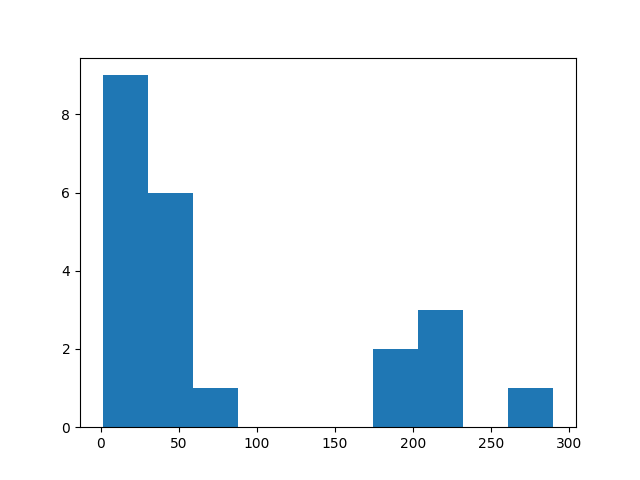

In [17]:
print(alt_hist)
plt.figure()
plt.hist(alt_hist)
plt.show()